**Leer archivos guardados desde el código de extracción y limpieza de datos**

In [ ]:
import os
import pandas as pd
data_path_2020 = os.path.join("..", "..", "Data","prestadores de salud", "egresos_covid_2020.csv")
df_2020 = pd.read_csv(data_path_2020, encoding="utf-8")
data_path_2021 = os.path.join("..", "..", "Data","prestadores de salud", "egresos_covid_2021.csv")
df_2021 = pd.read_csv(data_path_2021, encoding="utf-8")
data_path_2022 = os.path.join("..", "..", "Data","prestadores de salud", "egresos_covid_2022.csv")
df_2022 = pd.read_csv(data_path_2022, encoding="utf-8")
data_path = os.path.join("..", "..", "Data","prestadores de salud", "egresos_covid_todos.csv")
df = pd.read_csv(data_path, encoding="utf-8")
df.head(6)


,Sistema,Total_egresos,Egresos_COVID,%_COVID,%_COVID_num,Año
0,ISAPRE,373379,3903,1.05 %,1.045319,2020
1,FONASA,1277952,47081,3.68 %,3.684098,2020
2,ISAPRE,413087,8343,NaN,2.020000,2021
3,FONASA,1467062,89047,NaN,6.070000,2021
4,ISAPRE,468597,4034,NaN,0.860000,2022
5,FONASA,1540096,23980,NaN,1.560000,2022


**Crear graficos por año**

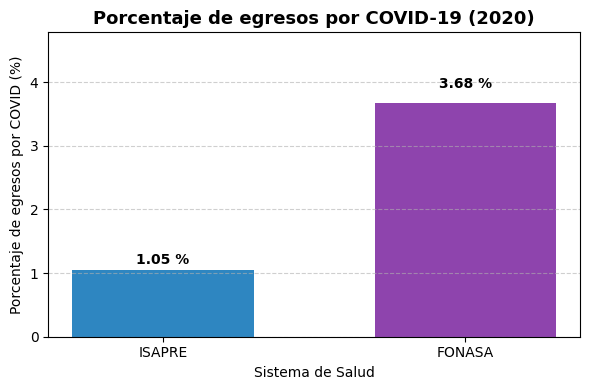

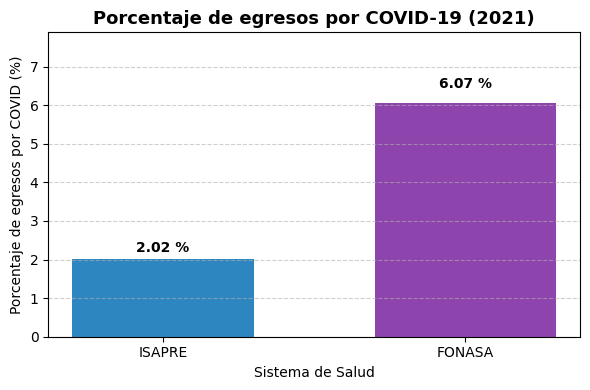

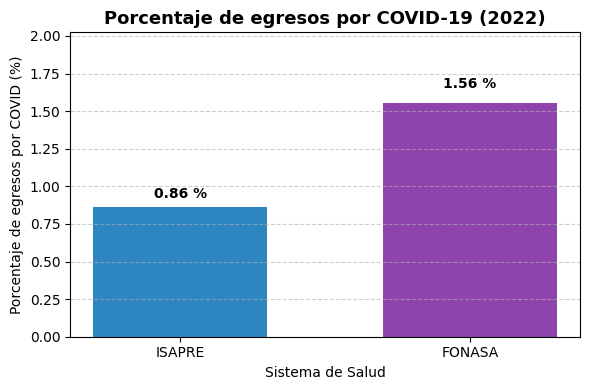

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def ensure_pct(df):
    df = df.copy()
    
    if "%_COVID" in df.columns and df["%_COVID"].notna().any():
        x = (df["%_COVID"].astype(str)
             .str.replace("%", "", regex=False)
             .str.replace(",", ".", regex=False))
        pct = pd.to_numeric(x, errors="coerce")
    else:
        
        pct = (pd.to_numeric(df["Egresos_COVID"], errors="coerce") /
               pd.to_numeric(df["Total_egresos"], errors="coerce")) * 100
    df["%_COVID_num"] = pct

    df["Sistema"] = df["Sistema"].astype(str).str.upper().str.strip()
    return df


df_2020_p = ensure_pct(df_2020)
df_2021_p = ensure_pct(df_2021)
df_2022_p = ensure_pct(df_2022)

def graficar_por_anio(df_anio, anio):
    d = df_anio.copy()
    
    order = ["ISAPRE", "FONASA"]
    d["Sistema"] = pd.Categorical(d["Sistema"], categories=order, ordered=True)
    d = d.sort_values("Sistema")
    colors = ["#2E86C1", "#8E44AD"]

    plt.figure(figsize=(6,4))
    bars = plt.bar(d["Sistema"], d["%_COVID_num"], color=colors, width=0.6)
    for b in bars:
        y = b.get_height()
        plt.text(b.get_x()+b.get_width()/2, y + (0.02 if y==0 else y*0.05),
                 f"{y:.2f} %", ha="center", va="bottom", fontsize=10, fontweight="bold")
    ymax = float(np.nanmax(d["%_COVID_num"])) if len(d) else 0.0
    plt.ylim(0, ymax*1.3 if ymax>0 else 1)
    plt.title(f"Porcentaje de egresos por COVID-19 ({anio})", fontsize=13, fontweight="bold")
    plt.ylabel("Porcentaje de egresos por COVID (%)")
    plt.xlabel("Sistema de Salud")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

graficar_por_anio(df_2020_p, 2020)
graficar_por_anio(df_2021_p, 2021)
graficar_por_anio(df_2022_p, 2022)




**Crear gráfico de todo el periodo**

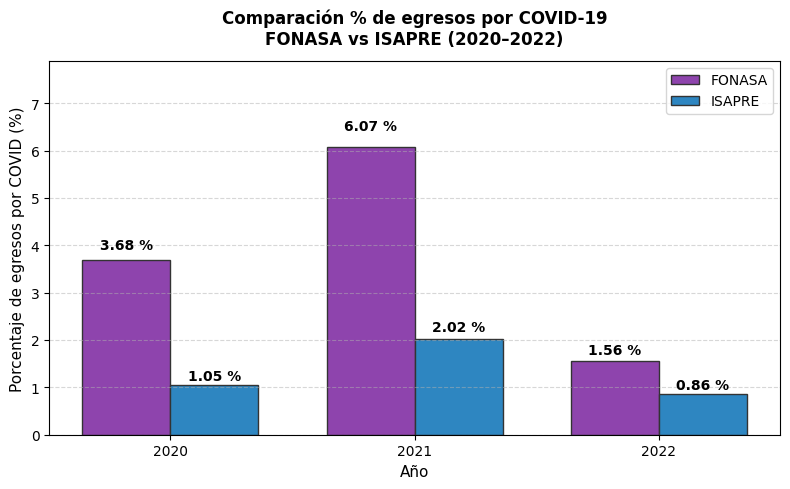

In [ ]:

comp = df.copy()

comp["Sistema"] = comp["Sistema"].astype(str).str.upper().str.strip()

comp["Año"] = (comp["Año"].astype(str)
               .str.extract(r"(\d{4})", expand=False)
               .astype(int))


if "%_COVID_num" in comp.columns:
    comp["%_COVID_num"] = pd.to_numeric(comp["%_COVID_num"], errors="coerce")
else:
    if "%_COVID" in comp.columns and comp["%_COVID"].notna().any():
        pct = (comp["%_COVID"].astype(str)
               .str.replace("%", "", regex=False)
               .str.replace(",", ".", regex=False))
        comp["%_COVID_num"] = pd.to_numeric(pct, errors="coerce")
    else:
        comp["%_COVID_num"] = (
            pd.to_numeric(comp["Egresos_COVID"], errors="coerce")
            / pd.to_numeric(comp["Total_egresos"], errors="coerce") * 100
        )


years = sorted(comp["Año"].unique())

def get_val(sistema, y):
    vals = comp.loc[(comp["Año"] == y) & (comp["Sistema"] == sistema), "%_COVID_num"].astype(float)
    return float(vals.iloc[0]) if len(vals) else np.nan

vals_fonasa = [get_val("FONASA", y) for y in years]
vals_isapre = [get_val("ISAPRE", y) for y in years]

x = np.arange(len(years))
width = 0.36

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, vals_fonasa, width, label="FONASA", color="#8E44AD", edgecolor="#333", linewidth=1.0)
bars2 = plt.bar(x + width/2, vals_isapre, width, label="ISAPRE", color="#2E86C1", edgecolor="#333", linewidth=1.0)

def annotate(bars):
    for b in bars:
        y = b.get_height()
        if np.isfinite(y):
            plt.text(b.get_x() + b.get_width()/2, y + (0.02 if y == 0 else y*0.05),
                     f"{y:.2f} %", ha="center", va="bottom", fontsize=10, fontweight="bold")

annotate(bars1); annotate(bars2)

all_vals = [v for v in (vals_fonasa + vals_isapre) if np.isfinite(v)]
ymax = max(all_vals) if all_vals else 0.0
plt.ylim(0, ymax*1.3 if ymax>0 else 1)
plt.xticks(x, [str(y) for y in years])
plt.xlabel("Año", fontsize=11)
plt.ylabel("Porcentaje de egresos por COVID (%)", fontsize=11)
plt.title("Comparación % de egresos por COVID-19\nFONASA vs ISAPRE (2020–2022)", pad=12, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
